In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
# bootstrapping to compute confidence interval
from scipy.stats import bootstrap

In [4]:
# survival analysis, lifelines library
import lifelines
from lifelines.utils import concordance_index

In [5]:
# survival analysis, scikit-survival library
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

In [6]:
from src.notebooks.survival import df_augment_surv, compute_and_plot_KM_sksurv

In [7]:
# %lsmagic

# Python libraries for survival analysis

**[lifelines](https://github.com/CamDavidsonPilon/lifelines)** - Survival analysis in Python<br>
<http://lifelines.readthedocs.org/>

2.2k stars, 70 watching, 583 forks, MIT license, CITATION.cff (DOI:10.5281/zenodo.805993), version 0.27.8, Development Status: 
4 - Bet<br>
first release on GitHub on Jun 11, 2014a

**[scikit-survival](https://github.com/sebp/scikit-survival)** - Survival analysis built on top of scikit-learn<br>
<https://scikit-survival.readthedocs.io/>

1k stars, 24 watching, 203 forks, GPL-3.0 license, citation in README.md (DOI:10.5281/zenodo.3352342), version 0.22.1, Development Status: 
4 - Bet<br>
first release on GitHub on May 29, 2017a

# Analyze survival stats of changed lines

For each commit in commit sharings in the DevGPT dataset, compute how many of changed lines (post-image lines, i.e. added lines in unified diff) survived to present, that is to `HEAD` revision.

The calculations were done using the [`compute_changes_survival.py`](../src/data/compute_changes_survival.py) script.

Below there is result of running some previous version of this script (excerpt):
```
$ python scripts/data/compute_changes_survival.py \
    data/interim/commit_sharings_df.csv data/repositories_download_status.json \
    data/interim/commit_sharings_changes_survival_df.csv \
    data/interim/commit_sharings_lines_survival_df.csv
Start time: 2023-11-22 23:08:02.088391 ==============================
Reading commit sharings data from 'data/interim/commit_sharings_df.csv'...
Loading info about cloned repos from 'data/repositories_download_status.json'...
Processing (694, 18) commit sharings data...
[...]
commit: 694it [01:41,  6.83it/s]
Skipped 5 rows because of an error
Created 76 of GitRepo objects
Lines survival stats:
  130298 / 169469 = 76.89% lines survived; 39171 did not
  orig commit metadata: 169221 from blame,   248 from repo = 169469 total
  last commit metadata: 169444 from blame,    25 from repo = 169469 total
  next commit metadata:  38929 from blame,   242 from repo =  39171 total
  515 from repo total
Creating dataframe with augmentation data from 694 records...
Creating dataframe with line survival data from 169469 records...
Merging (694, 18) with (694, 10) dataframes on 'Sha'...
Writing (696, 27) of augmented commit sharings data
  to 'data/interim/commit_sharings_changes_survival_df.csv'
Writing (169469, 16) of changed lines survival data
  to 'data/interim/commit_sharings_lines_survival_df.csv'
End time: 2023-11-22 23:09:45.434304 ================================
Function main() {} took 103.3454 seconds = 0:01:43.345356
```

In [8]:
df = pd.read_csv('../data/interim/commit_sharings_changes_survival_df.csv')

In [9]:
df.columns

Index(['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message',
       'AuthorAt', 'CommitAt', 'NumberOfChatgptSharings',
       'TotalNumberOfPrompts', 'TotalTokensOfPrompts', 'TotalTokensOfAnswers',
       'NumberOfConversations', 'TotalNumberOfCodeBlocks', 'ModelGPT4',
       'ModelGPT3_5', 'ModelOther', 'Status404', 'Sha_is_valid',
       'author_timestamp', 'committer_timestamp', 'n_parents',
       'is_merged_HEAD', 'number_of_commits_from_HEAD', 'error',
       'change_lines_survived', 'change_lines_total',
       'min_died_committer_timestamp'],
      dtype='object')

In [10]:
df['RepoName'].value_counts()

RepoName
tisztamo/Junior                                575
pbrudny/jobsforit-de                            16
hoshotakamoto/banzukesurfing                    15
kevinveenbirkenbach/computer-playbook            4
bh679/MindfulAI2.0                               4
                                              ... 
Hack23/cia                                       1
PyBites-Open-Source/italki-class-assistant       1
OKinane/spotify-to-youtube-chrome-extension      1
CPSC-1520/CPSC-1520-Workbook-A02-dgilleland      1
VoxturTijmen/Experimental                        1
Name: count, Length: 76, dtype: int64

In [11]:
# it is counting commits
df['RepoLanguage'].value_counts()

RepoLanguage
CSS                 614
HTML                 19
Python               14
Dockerfile            8
JavaScript            6
Shell                 5
Cython                4
C                     4
Batchfile             3
Lua                   2
Java                  2
Jinja                 1
Jupyter Notebook      1
C#                    1
Pascal                1
Go                    1
EJS                   1
GAML                  1
Name: count, dtype: int64

In [12]:
df_sel = df[[
    'RepoName', 'RepoLanguage', 'URL', 'Sha',
    'is_merged_HEAD', 'error', 'change_lines_survived', 'change_lines_total',
    #'min_died_committer_timestamp',
]]
df_sel

,RepoName,RepoLanguage,URL,Sha,is_merged_HEAD,error,change_lines_survived,change_lines_total
0,grnpin/textbox,HTML,https://github.com/grnpin/textbox/commit/fa335...,fa335cf2ec447d00f8e94b54a8b463725b92947c,True,False,0.0,13.0
1,grnpin/textbox,HTML,https://github.com/grnpin/textbox/commit/0dfc4...,0dfc4385b723060e1e6a21da17a952bd908084ff,True,False,2.0,119.0
2,grnpin/textbox,HTML,https://github.com/grnpin/textbox/commit/811d0...,811d09acdca361c81281c7d71587ebdbd8437453,True,False,3.0,35.0
3,bh679/MindfulAI2.0,CSS,https://github.com/bh679/MindfulAI2.0/commit/e...,e4a8c0fe3adfefb5922315c5b9df3c9cc4c0cff6,True,False,1.0,1.0
4,4lejandrito/fetchbook,JavaScript,https://github.com/4lejandrito/fetchbook/commi...,11725c1a23503f31f7b7cd13188c8d9e30e822a9,True,False,89.0,129.0
...,...,...,...,...,...,...,...,...
691,hoshotakamoto/banzukesurfing,HTML,https://github.com/hoshotakamoto/banzukesurfin...,d0a54935a6e665bfaaa858adb6afc42b231707fe,True,False,16.0,42.0
692,hoshotakamoto/banzukesurfing,HTML,https://github.com/hoshotakamoto/banzukesurfin...,90e1d68ddc8d3a2caa076ee4d423484bf0a742f3,True,False,11.0,33.0
693,hoshotakamoto/banzukesurfing,HTML,https://github.com/hoshotakamoto/banzukesurfin...,63b2ab90b0b138e509e87efad59fd72b414d0133,True,False,27.0,106.0
694,openai/evals,JavaScript,https://github.com/openai/evals/commit/771dce8...,771dce83870cb2e6ab6e99b1c96682de5658c210,True,False,12.0,12.0


In [13]:
df_sel[['is_merged_HEAD', 'error']].describe()

,is_merged_HEAD,error
count,696,696
unique,1,2
top,True,False
freq,696,691


In [14]:
df_sel['error'].value_counts()

error
False    691
True       5
Name: count, dtype: int64

This means that there were 5 cases where there was an error.<br>
In all cases the commit was merged into HEAD (it was most likely, as it is how it was found).

In [15]:
# we can skip those cases when there was an error
df_sel = df_sel[df_sel['error'] == False]

In [16]:
df_sel.loc[:,'change_lines_survived_perc'] = 100.0*df_sel['change_lines_survived']/df_sel['change_lines_total']

/tmp/ipykernel_286188/1979068965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel.loc[:,'change_lines_survived_perc'] = 100.0*df_sel['change_lines_survived']/df_sel['change_lines_total']


In [17]:
df_sel.describe()

,change_lines_survived,change_lines_total,change_lines_survived_perc
count,691.000000,691.000000,688.000000
mean,188.920405,245.610709,50.418306
std,2955.876717,2966.866913,44.196029
min,0.000000,0.000000,0.000000
25%,2.000000,41.000000,4.894180
50%,18.000000,79.000000,33.333333
75%,76.500000,129.500000,98.048643
max,77301.000000,77344.000000,100.000000


In [18]:
s_change_lines_sum = df_sel[['change_lines_survived', 'change_lines_total']].sum()
s_change_lines_sum

change_lines_survived    130544.0
change_lines_total       169717.0
dtype: float64

In [19]:
s_change_lines_sum['change_lines_survived']/s_change_lines_sum['change_lines_total']

0.769186351396737

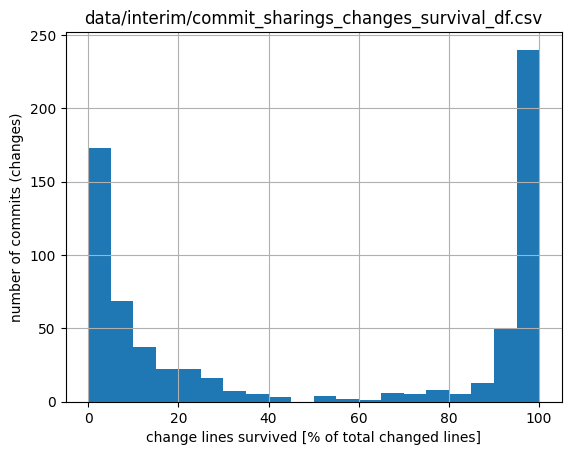

In [20]:
fig, ax = plt.subplots()
df_sel['change_lines_survived_perc'].hist(ax=ax, bins=20)
ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('number of commits (changes)')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

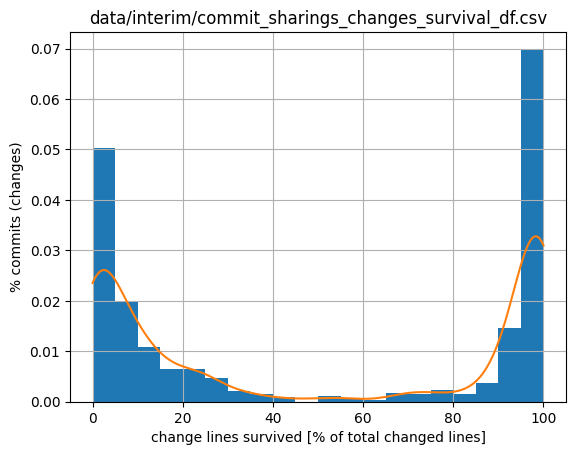

In [21]:
fig, ax = plt.subplots()

df_sel['change_lines_survived_perc'].hist(ax=ax, bins=20, density=True, grid=True)
df_sel['change_lines_survived_perc'].plot.kde(bw_method=0.1, ind=np.linspace(0, 100, num=1000, endpoint=True), grid=True)

ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('% commits (changes)')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

/tmp/ipykernel_286188/110446166.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_sel[['change_lines_survived', 'change_lines_total']].hist(ax=ax, range=(0,300), density=True)


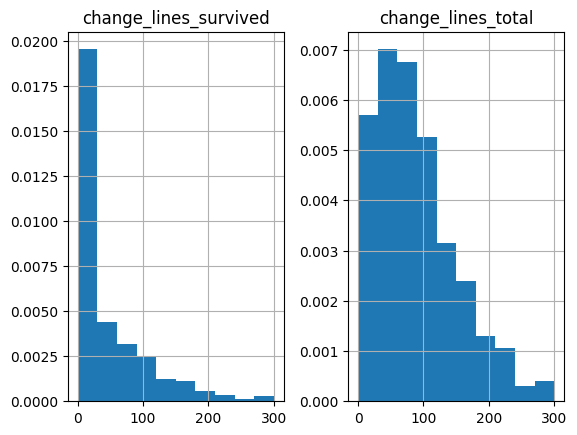

In [22]:
fig, ax = plt.subplots()
df_sel[['change_lines_survived', 'change_lines_total']].hist(ax=ax, range=(0,300), density=True)
ax.set_xlabel('change lines (cut off)')
ax.set_ylabel('% number of commits')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

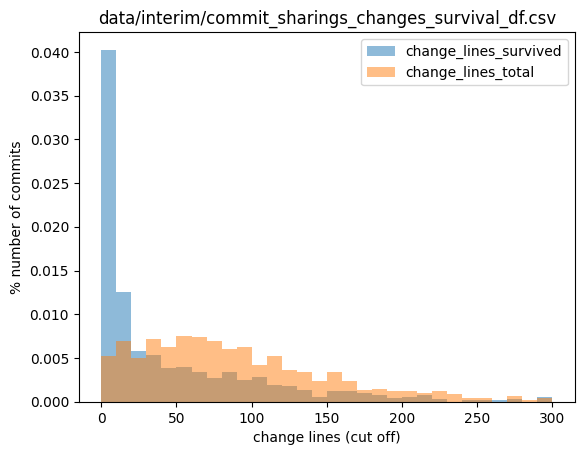

In [23]:
ax = df_sel[['change_lines_survived', 'change_lines_total']].plot.hist(bins=30, alpha=0.5, range=(0,300), density=True)
ax.set_xlabel('change lines (cut off)')
ax.set_ylabel('% number of commits')
ax.set_title('data/interim/commit_sharings_changes_survival_df.csv')

plt.show()

## With outlier tisztamo/Junior repo removed

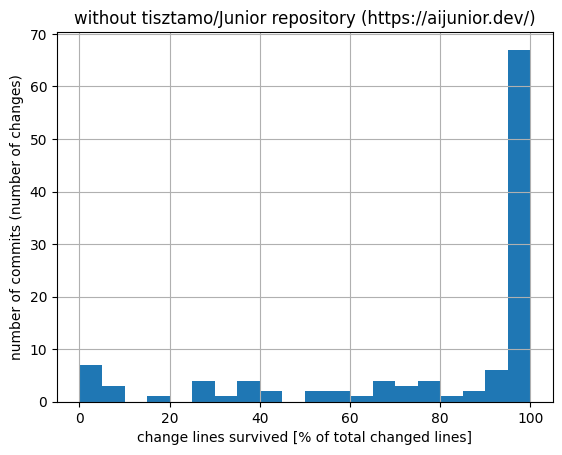

In [24]:
fig, ax = plt.subplots()

df_subsel = df_sel[df_sel['RepoName'] != 'tisztamo/Junior']

df_subsel['change_lines_survived_perc'].hist(ax=ax, bins=20, grid=True)

ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('number of commits (number of changes)')
ax.set_title('without tisztamo/Junior repository (https://aijunior.dev/)')

plt.show()

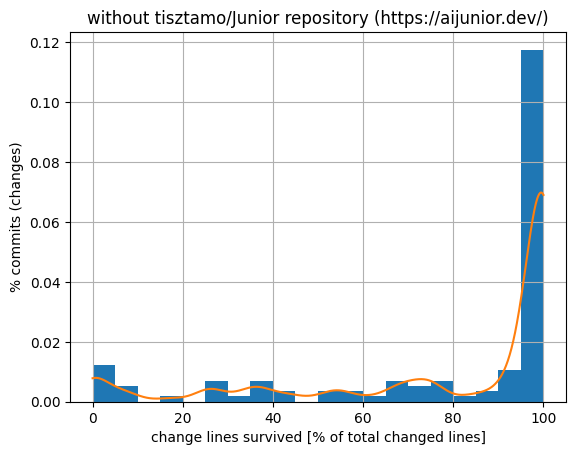

In [25]:
fig, ax = plt.subplots()

df_subsel = df_sel[df_sel['RepoName'] != 'tisztamo/Junior']

df_subsel['change_lines_survived_perc'].hist(ax=ax, bins=20, density=True, grid=True)
df_subsel['change_lines_survived_perc'].plot.kde(bw_method=0.1, ind=np.linspace(0, 100, num=1000, endpoint=True), grid=True)

ax.set_xlabel('change lines survived [% of total changed lines]')
ax.set_ylabel('% commits (changes)')
ax.set_title('without tisztamo/Junior repository (https://aijunior.dev/)')

plt.show()

In [26]:
df_subsel.describe()

,change_lines_survived,change_lines_total,change_lines_survived_perc
count,117.000000,117.000000,114.000000
mean,772.307692,804.769231,78.596199
std,7152.919448,7159.427417,32.436033
min,0.000000,0.000000,0.000000
25%,10.000000,14.000000,67.248062
50%,27.000000,39.000000,98.453966
75%,87.000000,114.000000,100.000000
max,77301.000000,77344.000000,100.000000


In [27]:
s_subsel_sum = df_subsel[['change_lines_survived', 'change_lines_total']].sum()
s_subsel_sum

change_lines_survived    90360.0
change_lines_total       94158.0
dtype: float64

In [28]:
print("Change lines that survived, as totals of all change lines")
print(f"{100.0*s_subsel_sum['change_lines_survived']/s_subsel_sum['change_lines_total']} % (without tisztamo/Junior)")
print(f"{100.0*s_change_lines_sum['change_lines_survived']/s_change_lines_sum['change_lines_total']} % (all)")

Change lines that survived, as totals of all change lines
95.96635442554005 % (without tisztamo/Junior)
76.9186351396737 % (all)


# Survival analysis of lines

**Survival analysis** is a branch of statistics for analyzing the expected duration of time until one event occurs, such as death in biological organisms and failure in mechanical systems. This topic is called _reliability theory_ or _reliability analysis_ in engineering, _duration analysis_ or _duration modelling_ in economics, and _event history analysis_ in sociology.

In our case we are interested in **lifetime** of _changes_ that were created with the help of ChatGPT.  In the case of this part of analysis, we analyze commits sharings from DevGPT dataset, that is commits where commit message includes `https://chat.openai.com/share/` link.

Let's define what the terms used in survival analysis mean in this analysis:
- an _event_ ("death") is the change vanishing, or rather the **change line** introduced by commit from the DevGPT dataset vanishing from code
- the _beginning of observation_ ("birth") is creation of the commit from the DevGPT dataset
- _censoring_ (_censored observation_) occurs when the change line did survive until the date the repository was cloned, and is still present in the code in HEAD in the project's repository

> **NOTE** that currently we do not take into consideration and into account whether a given line of change was taken from ChatGPT answer or not.

In [29]:
lines_df = pd.read_csv('../data/interim/commit_sharings_lines_survival_df.csv')

/tmp/ipykernel_286188/1010409278.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  lines_df = pd.read_csv('../data/interim/commit_sharings_lines_survival_df.csv')


In [30]:
lines_df.loc[:, 'has_next'] = lines_df['next_commit'].notna()
lines_df['has_next'].value_counts()

has_next
False    130298
True      39171
Name: count, dtype: int64

In [31]:
lines_df.columns

Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next'],
      dtype='object')

In [32]:
lines_df.dtypes

URL                          object
RepoName                     object
Sha                          object
Sha_filename                 object
Sha_lineno                    int64
last_commit                  object
last_filename                object
last_lineno                   int64
line                         object
diff_line_no                  int64
next_commit                  object
next_filename                object
Sha_author_timestamp          int64
Sha_committer_timestamp       int64
last_author_timestamp         int64
last_committer_timestamp      int64
next_author_timestamp       float64
next_committer_timestamp    float64
has_next                       bool
dtype: object

In [33]:
# counting lines, in commits, in repositories
lines_df['RepoName'].value_counts()

RepoName
p3ob7o/Speak                             77344
tisztamo/Junior                          75559
hoshotakamoto/banzukesurfing              5802
Buildstarted/linksfordevs                 3378
pbrudny/jobsforit-de                      1375
                                         ...  
TurboWarp/extensions                         4
jordanbell2357/resume                        4
The-Poolz/EthSmartContractIO                 3
eshreyareddy/prompting-zomato-reviews        1
SupraSensum/TOP-project-etch-a-sketch        1
Name: count, Length: 70, dtype: int64

In [34]:
print(f"There are {len(lines_df['RepoName'].unique())} unique GitHub repositories ('RepoName')")
for repo in lines_df['RepoName'].value_counts().index:
    print(f"  https://github.com/{repo}")

There are 70 unique GitHub repositories ('RepoName')
  https://github.com/p3ob7o/Speak
  https://github.com/tisztamo/Junior
  https://github.com/hoshotakamoto/banzukesurfing
  https://github.com/Buildstarted/linksfordevs
  https://github.com/pbrudny/jobsforit-de
  https://github.com/jimfergusondev/ChatGPTBuildsDelphiPolygonIOApiCalls
  https://github.com/multi-imcookie/cookies
  https://github.com/labd/terraform-provider-storyblok
  https://github.com/mgalgs/conf-files
  https://github.com/naomiajacobs/ColorPaletteReactTutorial
  https://github.com/damus-io/nostrdb
  https://github.com/eodinzov94/IsraFit
  https://github.com/Karunamon/pixlbot
  https://github.com/HolyBarrel/CPP-Udemy-Course
  https://github.com/elliotrichh/github1
  https://github.com/waylon620/GPT-tutor
  https://github.com/grnpin/textbox
  https://github.com/kevinveenbirkenbach/computer-playbook
  https://github.com/cwerdna19/ghoul-traders
  https://github.com/mgalgs/github-pr-fetch
  https://github.com/4lejandrito/f

In [35]:
lines_df['RepoName'].value_counts().loc[['zzzeek/sqlalchemy','sqlalchemy/sqlalchemy']]

RepoName
zzzeek/sqlalchemy        124
sqlalchemy/sqlalchemy    124
Name: count, dtype: int64

In [36]:
lines_df[lines_df['RepoName'] == 'sqlalchemy/sqlalchemy']['has_next'].value_counts()

has_next
False    123
True       1
Name: count, dtype: int64

In [37]:
lines_df.groupby('RepoName')['has_next'].sum().sort_values()

RepoName
winksaville/scripts                           0
openai/evals                                  0
naomiajacobs/ColorPaletteReactTutorial        0
The-Poolz/EthSmartContractIO                  0
poki/netlib                                   0
                                          ...  
grnpin/textbox                              162
multi-imcookie/cookies                      172
hoshotakamoto/banzukesurfing                215
Buildstarted/linksfordevs                  2112
tisztamo/Junior                           35375
Name: has_next, Length: 70, dtype: int64

In [38]:
s_has_next = lines_df.groupby('RepoName')['has_next'].sum()
s_has_next[s_has_next > 0].sort_values()

RepoName
Atulaya123/reddit-next13-prisma-sql                     1
Cissucalris9/cuemaker2                                  1
SupraSensum/TOP-project-etch-a-sketch                   1
VoxturTijmen/Experimental                               1
jordanbell2357/resume                                   1
dbt-labs/docs.getdbt.com                                1
zzzeek/sqlalchemy                                       1
larrywright/larrywright.me                              1
sqlalchemy/sqlalchemy                                   1
temporalio/temporal                                     1
DuarteSerrao/TS                                         2
kevinveenbirkenbach/cli-gnome-extension-manager         2
lightward/mechanic-tasks                                3
elouanb7/MSPR-B3-Deploiement-appli                      4
labd/terraform-provider-storyblok                       4
damus-io/nostrdb                                        5
GillyRabutTsurwa/su-2025-rest-api                       5
knowl

In [39]:
lines_df.loc[:,'Sha_committer_time']  = pd.to_datetime(lines_df['Sha_committer_timestamp'], unit='s')
lines_df.loc[:,'last_committer_time'] = pd.to_datetime(lines_df['last_committer_timestamp'], unit='s')
lines_df.loc[:,'next_committer_time'] = pd.to_datetime(lines_df['next_committer_timestamp'], unit='s')

In [40]:
lines_df.describe()

,Sha_lineno,last_lineno,diff_line_no,Sha_author_timestamp,Sha_committer_timestamp,last_author_timestamp,last_committer_timestamp,next_author_timestamp,next_committer_timestamp,Sha_committer_time,last_committer_time,next_committer_time
count,169469.000000,169469.000000,169469.000000,1.694690e+05,1.694690e+05,1.694690e+05,1.694690e+05,3.917100e+04,3.917100e+04,169469,169469,39171
mean,784.948038,885.959633,19053.992087,1.690249e+09,1.690250e+09,1.691991e+09,1.691991e+09,1.691299e+09,1.691299e+09,2023-07-25 01:46:45.950439680,2023-08-14 05:38:14.040975360,2023-08-06 05:21:20.915115520
min,1.000000,1.000000,6.000000,1.685180e+09,1.685180e+09,1.685182e+09,1.685182e+09,1.685221e+09,1.685221e+09,2023-05-27 09:39:31,2023-05-27 09:59:37,2023-05-27 21:04:22
25%,29.000000,29.000000,173.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.690007e+09,1.690007e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-07-22 06:22:26
50%,93.000000,95.000000,3254.000000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691228e+09,1.691228e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-05 09:32:21
75%,585.000000,626.000000,36663.000000,1.691532e+09,1.691532e+09,1.697911e+09,1.697911e+09,1.692173e+09,1.692173e+09,2023-08-08 22:08:19,2023-10-21 18:02:34,2023-08-16 08:11:02
max,15242.000000,15129.000000,82176.000000,1.696945e+09,1.696945e+09,1.701139e+09,1.701139e+09,1.699471e+09,1.699471e+09,2023-10-10 13:44:49,2023-11-28 02:35:41,2023-11-08 19:12:42
std,1607.755683,1880.820596,25442.242301,2.240694e+06,2.241184e+06,4.354896e+06,4.354901e+06,1.747924e+06,1.747994e+06,NaN,NaN,NaN


The presence of not N/A **`next_commit`** will be used as _'event observed'_ column

In [41]:
lines_df.loc[:, 'survival_duration'] = lines_df['next_committer_time'] - lines_df['Sha_committer_time']

In [42]:
lines_df['survival_duration']

0        44 days 17:27:13
1        44 days 17:27:13
2        44 days 17:27:13
3         0 days 00:16:42
4        44 days 17:27:13
               ...       
169464                NaT
169465                NaT
169466                NaT
169467                NaT
169468                NaT
Name: survival_duration, Length: 169469, dtype: timedelta64[ns]

In [43]:
lines_df.loc[:, 'survival_duration_days'] = lines_df['survival_duration'].dt.total_seconds()/(60*60*24)
lines_df['survival_duration_days']

0         44.727234
1         44.727234
2         44.727234
3          0.011597
4         44.727234
            ...    
169464          NaN
169465          NaN
169466          NaN
169467          NaN
169468          NaN
Name: survival_duration_days, Length: 169469, dtype: float64

In [44]:
lines_df['survival_duration_days'].describe()

count    39171.000000
mean         5.725990
std         15.639174
min          0.000012
25%          0.014734
50%          0.071563
75%          1.001898
max        111.494988
Name: survival_duration_days, dtype: float64

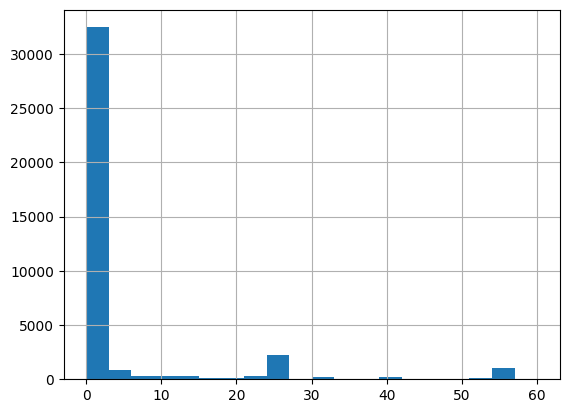

In [45]:
ax = lines_df['survival_duration_days'].hist(bins=20, range=(0,60))

In [46]:
lines_df.loc[:, 'unchanged_duration'] = lines_df['last_committer_time'] - lines_df['Sha_committer_time']
lines_df['unchanged_duration'].describe()

count                        169469
mean     20 days 03:51:28.090535732
std      35 days 00:17:38.271843687
min                 0 days 00:00:00
25%                 0 days 00:44:23
50%                 0 days 00:44:23
75%                35 days 07:57:45
max               161 days 03:57:24
Name: unchanged_duration, dtype: object

In [47]:
lines_df.loc[:, 'unchanged_duration_days'] = lines_df['unchanged_duration'].dt.total_seconds()/(60*60*24)
lines_df['unchanged_duration_days']

0         44.707662
1         44.707662
2         44.707662
3          0.007095
4         44.707662
            ...    
169464     2.065972
169465     2.065972
169466     2.065972
169467     2.065972
169468     2.065972
Name: unchanged_duration_days, Length: 169469, dtype: float64

In [48]:
lines_df.loc[ lines_df['has_next'], 'observed_duration'] = lines_df['survival_duration']
lines_df.loc[~lines_df['has_next'], 'observed_duration'] = lines_df['unchanged_duration']
lines_df['observed_duration']

0        44 days 17:27:13
1        44 days 17:27:13
2        44 days 17:27:13
3         0 days 00:16:42
4        44 days 17:27:13
               ...       
169464    2 days 01:35:00
169465    2 days 01:35:00
169466    2 days 01:35:00
169467    2 days 01:35:00
169468    2 days 01:35:00
Name: observed_duration, Length: 169469, dtype: timedelta64[ns]

In [49]:
lines_df.loc[:, 'observed_duration_days'] = lines_df['observed_duration'].dt.total_seconds()/(60*60*24)
lines_df['observed_duration_days']

0         44.727234
1         44.727234
2         44.727234
3          0.011597
4         44.727234
            ...    
169464     2.065972
169465     2.065972
169466     2.065972
169467     2.065972
169468     2.065972
Name: observed_duration_days, Length: 169469, dtype: float64

## Kaplan-Meier estimation of survival function

In [50]:
kmf_l = lifelines.KaplanMeierFitter()

In [51]:
T = lines_df['observed_duration_days']
E = lines_df['has_next']

In [52]:
kmf_l.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 169469 total observations, 130298 right-censored observations>

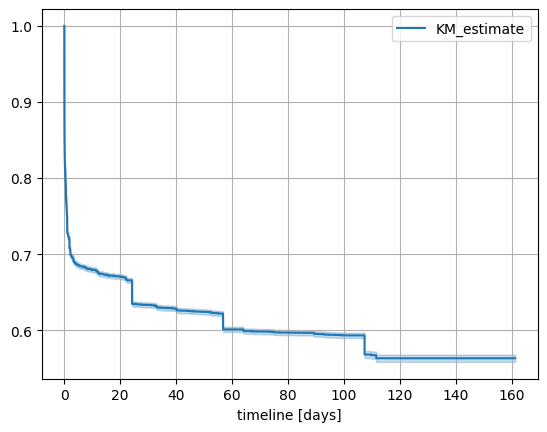

In [53]:
ax = kmf_l.plot_survival_function(grid=True)
ax.set_xlabel('timeline [days]')

plt.show()

In [54]:
table_l = lifelines.utils.survival_table_from_events(T, E)
print(table_l.head())

          removed  observed  censored  entrance  at_risk
event_at                                                
0.000000      794         0       794    169469   169469
0.000012        6         6         0         0   168675
0.000868       13        13         0         0   168669
0.001100        1         1         0         0   168656
0.001181        2         2         0         0   168655


In [55]:
# For less visual clutter, you may want to subsample to less than 25 individuals.
#ax = lifelines.plotting.plot_lifetimes(T, event_observed=E)

#plt.show()

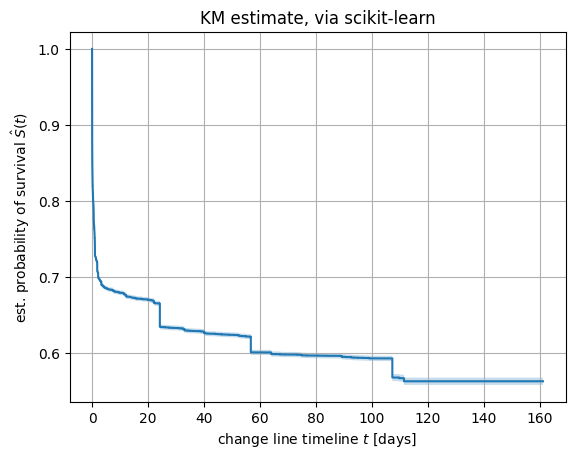

In [56]:
# https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#The-Survival-Function

time, survival_prob, conf_int = kaplan_meier_estimator(
    E, T, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
#plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn")
plt.grid()

plt.show()

## KM estimation, with outlier tisztamo/Junior repo removed

In [57]:
lines_df_subsel = lines_df[lines_df['RepoName'] != 'tisztamo/Junior']
lines_df_subsel.describe()

,Sha_lineno,last_lineno,diff_line_no,Sha_author_timestamp,Sha_committer_timestamp,last_author_timestamp,last_committer_timestamp,next_author_timestamp,next_committer_timestamp,Sha_committer_time,last_committer_time,next_committer_time,survival_duration,survival_duration_days,unchanged_duration,unchanged_duration_days,observed_duration,observed_duration_days
count,93910.000000,93910.000000,93910.000000,9.391000e+04,9.391000e+04,9.391000e+04,9.391000e+04,3.796000e+03,3.796000e+03,93910,93910,3796,3796,3796.000000,93910,93910.000000,93910,93910.000000
mean,646.243318,677.193121,33758.510872,1.689021e+09,1.689023e+09,1.689334e+09,1.689334e+09,1.691785e+09,1.691785e+09,2023-07-10 20:55:19.488627456,2023-07-14 11:34:42.786423296,2023-08-11 20:14:07.839041280,4 days 12:58:39.669125395,4.540737,3 days 14:39:23.297795761,3.610686,3 days 16:08:56.179682674,3.672872
min,1.000000,1.000000,6.000000,1.685180e+09,1.685180e+09,1.685182e+09,1.685182e+09,1.685221e+09,1.685221e+09,2023-05-27 09:39:31,2023-05-27 09:59:37,2023-05-27 21:04:22,0 days 00:00:01,0.000012,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000
25%,55.000000,56.000000,7523.250000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691543e+09,1.691543e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-09 01:09:17,0 days 13:58:06,0.582014,0 days 00:44:23,0.030822,0 days 00:44:23,0.030822
50%,178.000000,189.000000,31821.500000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691619e+09,1.691619e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-09 22:11:03,1 days 00:02:44,1.001898,0 days 00:44:23,0.030822,0 days 00:44:23,0.030822
75%,686.000000,738.000000,56715.750000,1.688660e+09,1.688660e+09,1.688663e+09,1.688663e+09,1.691718e+09,1.691718e+09,2023-07-06 16:20:49,2023-07-06 17:05:12,2023-08-11 01:39:34.750000128,1 days 02:06:12,1.087639,0 days 00:44:23,0.030822,0 days 00:44:23,0.030822
max,15242.000000,15129.000000,82176.000000,1.696945e+09,1.696945e+09,1.701139e+09,1.701139e+09,1.699471e+09,1.699471e+09,2023-10-10 13:44:49,2023-11-28 02:35:41,2023-11-08 19:12:42,97 days 10:41:04,97.445185,161 days 03:57:24,161.164861,161 days 03:57:24,161.164861
std,1037.704465,1105.618453,26109.186050,1.325254e+06,1.327972e+06,2.271022e+06,2.271077e+06,2.375265e+06,2.375745e+06,NaN,NaN,NaN,12 days 12:46:07.190316380,12.532028,16 days 10:18:49.079894875,16.429735,16 days 12:38:39.003484764,16.526840


In [58]:
T_sel = lines_df_subsel['observed_duration_days']
E_sel = lines_df_subsel['has_next']

E_sel.value_counts()

has_next
False    90114
True      3796
Name: count, dtype: int64

In [59]:
kmf_l.fit(T_sel, event_observed=E_sel)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 93910 total observations, 90114 right-censored observations>

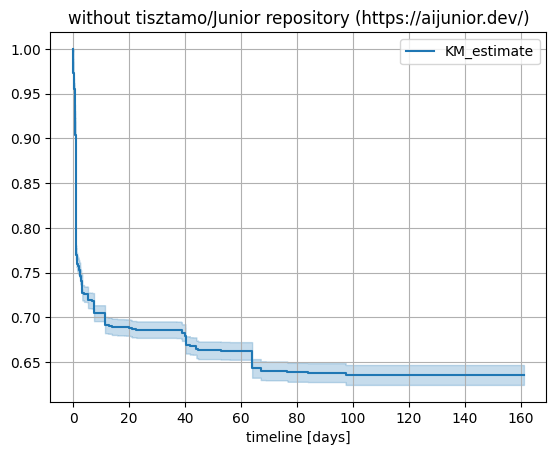

In [60]:
ax = kmf_l.plot_survival_function(grid=True)
ax.set_xlabel('timeline [days]')
ax.set_title('without tisztamo/Junior repository (https://aijunior.dev/)')

plt.show()

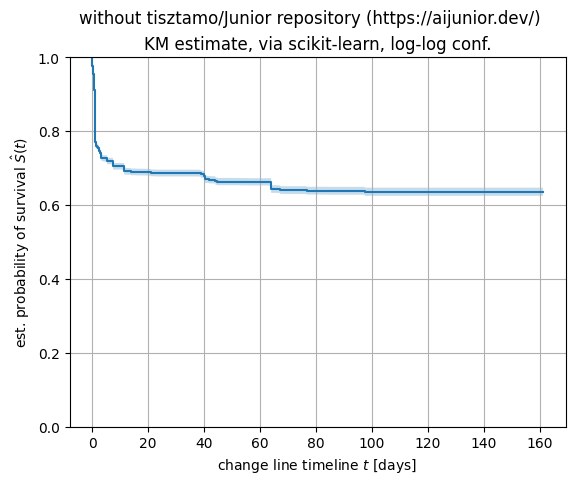

In [61]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    E_sel, T_sel, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn, log-log conf.")
plt.suptitle('without tisztamo/Junior repository (https://aijunior.dev/)')
plt.grid()

plt.show()

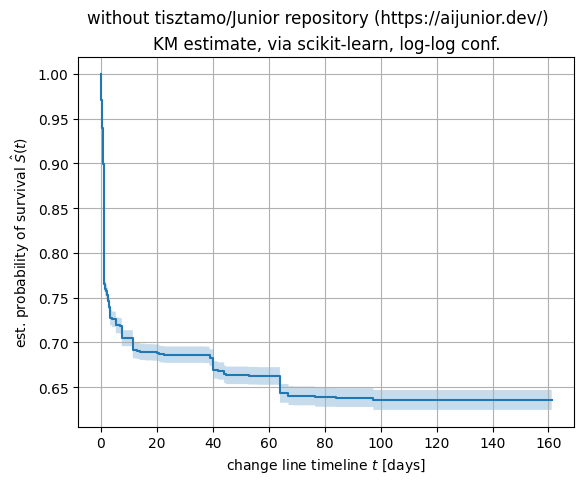

In [62]:
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
#plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn, log-log conf.")
plt.suptitle('without tisztamo/Junior repository (https://aijunior.dev/)')
plt.grid()

plt.show()

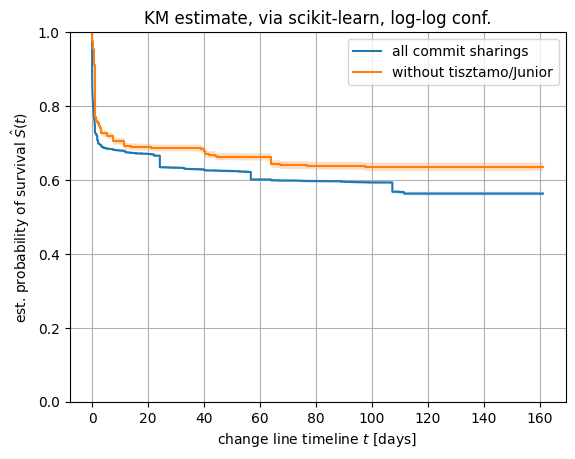

In [63]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    E, T, conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="all commit sharings")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time_sel, survival_prob_sel, conf_int_sel = kaplan_meier_estimator(
    E_sel, T_sel, conf_type="log-log"
)
plt.step(time_sel, survival_prob_sel, where="post", label="without tisztamo/Junior")
plt.fill_between(time_sel, conf_int_sel[0], conf_int_sel[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("change line timeline $t$ [days]")
plt.title("KM estimate, via scikit-learn, log-log conf.")
plt.grid()
plt.legend()

plt.show()

# Testing helper functions from `src.notebooks.survival`

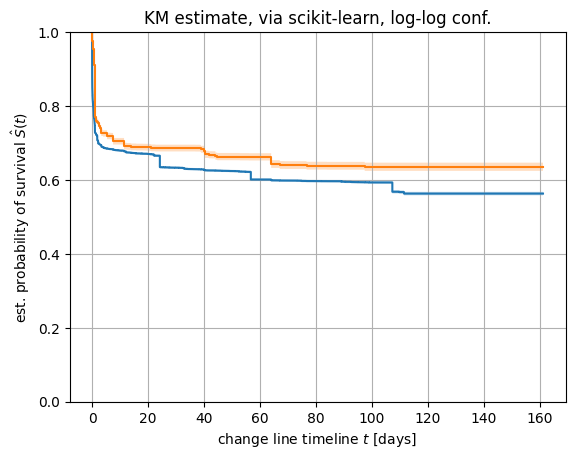

In [64]:
compute_and_plot_KM_sksurv(E, T, "all commit sharings")
compute_and_plot_KM_sksurv(E_sel, T_sel, "without outlier repo")
plt.grid()
plt.show()

# Commit, issue, and PR sharings compared

In [65]:
df_commit = pd.read_csv('../data/interim/commit_sharings_lines_survival_df.csv', low_memory=False)
df_augment_surv(df_commit)
df_commit.dtypes

URL                                  object
RepoName                             object
Sha                                  object
Sha_filename                         object
Sha_lineno                            int64
last_commit                          object
last_filename                        object
last_lineno                           int64
line                                 object
diff_line_no                          int64
next_commit                          object
next_filename                        object
Sha_author_timestamp                  int64
Sha_committer_timestamp               int64
last_author_timestamp                 int64
last_committer_timestamp              int64
next_author_timestamp               float64
next_committer_timestamp            float64
has_next                               bool
Sha_committer_time           datetime64[ns]
last_committer_time          datetime64[ns]
next_committer_time          datetime64[ns]
survival_duration           time

In [66]:
df_pr = pd.read_csv('../data/interim/pr_sharings_lines_survival_df.csv', low_memory=False)
df_augment_surv(df_pr)
df_pr.columns

Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E'],
      dtype='object')

In [67]:
df_issue = pd.read_csv('../data/interim/issue_sharings_lines_survival_df.csv', low_memory=False)
df_augment_surv(df_issue)
df_issue.columns

Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E'],
      dtype='object')

In [68]:
print(f"df_commit shape: {df_commit.shape}")
print(f"df_pr     shape: {df_pr.shape}")
print(f"df_issue  shape: {df_issue.shape}")

df_commit shape: (169469, 30)
df_pr     shape: (126967, 30)
df_issue  shape: (71521, 30)


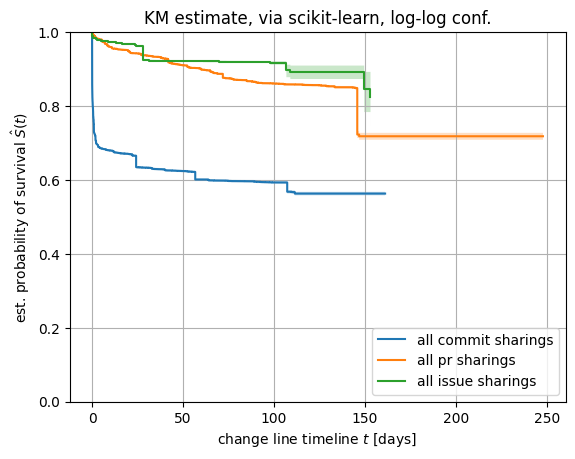

In [69]:
compute_and_plot_KM_sksurv(df_commit['E'], df_commit['T'], "all commit sharings")
compute_and_plot_KM_sksurv(df_pr['E'],     df_pr['T'],     "all pr sharings")
compute_and_plot_KM_sksurv(df_issue['E'],  df_issue['T'],  "all issue sharings")

plt.legend(loc='lower right')
plt.grid()
plt.grid()
plt.grid()
plt.show()

## Outlier projects detection

Outliers detection using total change lines count

In [70]:
df_commit['RepoName'].value_counts()

RepoName
p3ob7o/Speak                             77344
tisztamo/Junior                          75559
hoshotakamoto/banzukesurfing              5802
Buildstarted/linksfordevs                 3378
pbrudny/jobsforit-de                      1375
                                         ...  
TurboWarp/extensions                         4
jordanbell2357/resume                        4
The-Poolz/EthSmartContractIO                 3
eshreyareddy/prompting-zomato-reviews        1
SupraSensum/TOP-project-etch-a-sketch        1
Name: count, Length: 70, dtype: int64

- [p3ob7o/Speak](https://github.com/p3ob7o/Speak): A simple tool to transcribe and summarize notes<br>
  1 author, 64 commits, 1 very large commit (see below) with large changes:
    - Refactored entirely based on https://chat.openai.com/share/c89e041e-e…a23-42f9-972f-8543f4407db (commit [01cec3e3](https://github.com/p3ob7o/Speak/commit/01cec3e3d17e26f703ce8bf7aa068d3f6b6364d3))<br>
      **560 changed files** with **80,480 additions** and **147 deletions**<br>
    - Deleted entirely in HEAD:<br>
      Starting Over (commit [a41023ff](https://github.com/p3ob7o/Speak/commit/a41023ffa6887df1436518ffef1a1c65c97b5ae9))<br>
      **856 changed files** with **0 additions** and **124,322 deletions**7

In [71]:
df_commit[df_commit['RepoName'] == 'p3ob7o/Speak']['Sha'].value_counts()

Sha
01cec3e3d17e26f703ce8bf7aa068d3f6b6364d3    77344
Name: count, dtype: int64

- [tisztamo/Junior](https://github.com/tisztamo/Junior): AI-First IDE. Also codes itself fully: No code was written by humans here.<br>
  single core author: [tisztamo](https://github.com/tisztamo), 889 commits on the main branch, 574 of which are in DevGPT

In [72]:
df_commit[df_commit['RepoName'] == 'tisztamo/Junior']['Sha'].value_counts()

Sha
0f993913a84f5f62efe9277ad430b4f0d1fbbb8a    6476
009032085fbfdc641458e38c05a0e2c9ec9f6572    4447
f31a28cc1976d4bbe0ced316f39c0b185aa3d4bf    3344
d40a7a626e73e556daeef659ff24b6705e3c537f    3235
02036baf64809d4159f55865b2b90d53a9a6feeb     853
                                            ... 
40722e558af611a23ba88daaa87f04d15ff5db51       3
3f84389921c7963e1100802462a214dcb576f2dc       2
fc323822cfba6fb48249375588a6bccd71edc3aa       2
c3c00ff8754b887a83e8f430c14b0fadc10ed01a       1
86a1754553dc93cb6316798a8ff484b37d087562       1
Name: count, Length: 574, dtype: int64

In [73]:
df_commit.loc[:, 'outlier'] = False
df_commit.loc[df_commit['RepoName'] == 'p3ob7o/Speak', 'outlier'] = True
df_commit.loc[df_commit['RepoName'] == 'tisztamo/Junior', 'outlier'] = True

df_commit[df_commit['outlier']]['RepoName'].value_counts()

RepoName
p3ob7o/Speak       77344
tisztamo/Junior    75559
Name: count, dtype: int64

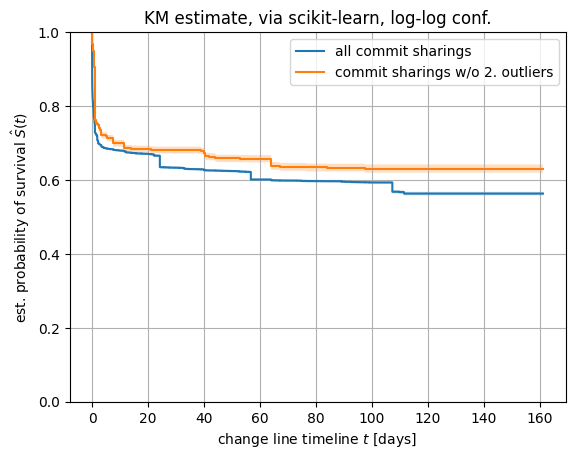

In [74]:
compute_and_plot_KM_sksurv(df_commit['E'], df_commit['T'], "all commit sharings")
compute_and_plot_KM_sksurv(df_commit[~df_commit['outlier']]['E'],
                           df_commit[~df_commit['outlier']]['T'], "commit sharings w/o 2. outliers")

plt.legend()
plt.grid()
plt.show()

In [75]:
df_pr['RepoName'].value_counts()

RepoName
Email-Generation/email_generation    53896
rehypejs/camomile                     6134
hoshotakamoto/banzukesurfing          5802
toptal/picasso                        4671
VOICEVOX/voicevox_core                3711
                                     ...  
cataclysmbnteam/Cataclysm-BN             1
JJConsulting/JJMasterData                1
metaphorsystems/metaphor-python          1
justinjeong5/j-chat                      1
whatwg/whatwg.org                        1
Name: count, Length: 143, dtype: int64

In [76]:
df_pr[df_pr['RepoName'] == 'Email-Generation/email_generation']['Sha'].value_counts()

Sha
4a318af10ae526eef735eb4a384beb834ad9cfef    53896
Name: count, dtype: int64

- [Email-Generation/email_generation](https://github.com/Email-Generation/email_generation):
  Auto Email Generation is a project that utilizes FastAPI for the backend and a React frontend
  to automatically generate emails based on user input using the OpenAI API.<br>
  2 contributors, 1 core contributor, 120 commits, 4 pull requests
    - single merge commit, for a single pull request (commit [4a318af1](https://github.com/Email-Generation/email_generation/commit/4a318af10ae526eef735eb4a384beb834ad9cfef)):<br>
      Merge pull request [#2](https://github.com/Email-Generation/email_generation/pull/2) from Email-Generation/linting-and-formatting-worrkflow<br>
      **28 changed files** with **53,896 additions** and **37,270 deletions** (merge)<br>
      submitted as series of 50 comits; ChatGPT link in comment: <https://chat.openai.com/share/c9e107c8-e424-4260-a85e-0bffcf334e2b>s

In [77]:
df_pr.loc[:, 'outlier'] = False
df_pr.loc[df_pr['RepoName'] == 'Email-Generation/email_generation', 'outlier'] = True

df_pr[df_pr['outlier']]['RepoName'].value_counts()

RepoName
Email-Generation/email_generation    53896
Name: count, dtype: int64

In [78]:
df_pr[df_pr['T'] > 150][['RepoName', 'Sha']].value_counts()

RepoName                             Sha                                     
ggerganov/llama.cpp                  99009e72f8072fa552eb02efee436be596c71cdd    1704
dust-tt/dust                         dbd4aec780ac19272405acff271e34d0e45b9968    1059
decred/dcrdex                        05ad13a1e7ae87b6f5ae6c01bfaedca7545de757     759
snapshot-labs/snapshot               4186b4e205212c505361b0d771923471d5d5e80f     121
citusdata/activerecord-multi-tenant  7b6bb2fe90c63e8c9dc868b476dfb35160bf0685      27
astahmer/openapi-zod-client          a5dc1c4fb7a10faecb0df2687c3d96e75494d722      19
2Abendsegler/GClh                    556d92ba907a536971fae792561771de28cdf1a1      10
Name: count, dtype: int64

In [79]:
df_pr[df_pr['T'] > 150]['RepoName'].value_counts()

RepoName
ggerganov/llama.cpp                    1704
dust-tt/dust                           1059
decred/dcrdex                           759
snapshot-labs/snapshot                  121
citusdata/activerecord-multi-tenant      27
astahmer/openapi-zod-client              19
2Abendsegler/GClh                        10
Name: count, dtype: int64

In [80]:
df_pr[(df_pr['T'] > 125) & (df_pr['T'] < 150)][['RepoName', 'Sha']].value_counts()

RepoName                                 Sha                                     
wahanegi/vibereport                      e6ea1c58d6c7d1e5e053eb8cbd8c13b1ba8b4575    1892
tic-oss/jhipster-blueprints              f9edc7487267e33717b0111ad554259616c3cc08    1119
mindee/doctr                             c09cc8037df267c76b7cc7b5d04b2857e59d05d1     883
ggerganov/llama.cpp                      99009e72f8072fa552eb02efee436be596c71cdd     738
dotCMS/core                              a34f8e2c420f2c6117c94b784a9bae1d162281c3     619
internetarchive/iaux-collection-browser  ea10a654244b27c2234d66120bbf8d37655ced67     565
SchemaStore/schemastore                  724f5e77d03dd824f2bfd71ad290a1c9f59dde5a     239
jhipster/generator-jhipster              bdb0ac9c6db961d58379e7d31673b7d68c56dcf1     170
daydule/frontend                         5cc3acd455fd5467562b36f061254b5c6216906a     111
ggerganov/llama.cpp                      74a6d922f12ccfe16b0c265f43be8978c6f25e98     104
arrocke/gloss-tran

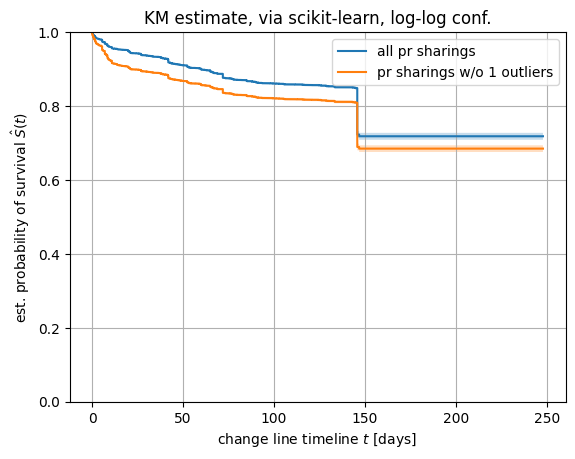

In [81]:
compute_and_plot_KM_sksurv(df_pr['E'], df_pr['T'], "all pr sharings")
compute_and_plot_KM_sksurv(df_pr[~df_pr['outlier']]['E'],
                           df_pr[~df_pr['outlier']]['T'], "pr sharings w/o 1 outliers")

plt.legend()
plt.grid()
plt.show()

In [82]:
df_issue['RepoName'].value_counts()

RepoName
neilenns/vatsim-plan-verifier                       31199
openactive/dataset-utils                            13887
MatrixAI/js-ws                                       9789
virtual-labs/exp-transistor-level-inverter-iiith     4904
virtual-labs/exp-transistor-level-nand-iiith         4347
nyx-space/anise                                      1423
byronwall/kids-reading                                624
simonw/symbex                                         509
HumanCompatibleAI/tensor-trust                        345
Fredkiss3/gh-next                                     343
tyamap/form-sales-helper                              305
ubiquity/ubiquibot                                    286
clojure-emacs/orchard                                 270
violentmonkey/violentmonkey                           212
garymm/starflate                                      203
erikengervall/fast-find-in-files                      189
The-Poolz/EthSmartContractIO                          183
mprib

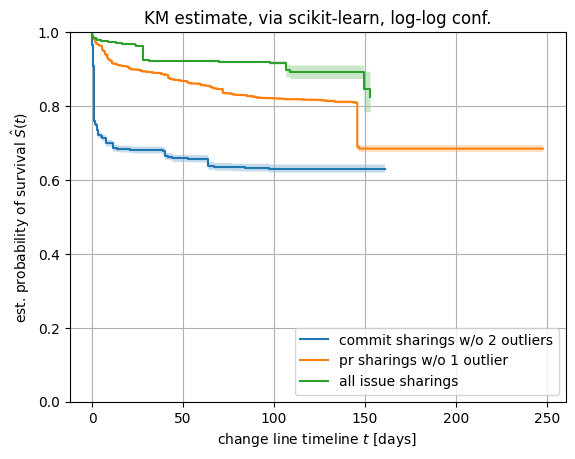

In [83]:
compute_and_plot_KM_sksurv(df_commit[~df_commit['outlier']]['E'],
                           df_commit[~df_commit['outlier']]['T'], "commit sharings w/o 2 outliers")
compute_and_plot_KM_sksurv(df_pr[~df_pr['outlier']]['E'],
                           df_pr[~df_pr['outlier']]['T'],  "pr sharings w/o 1 outlier")
compute_and_plot_KM_sksurv(df_issue['E'],  df_issue['T'],  "all issue sharings")

plt.legend(loc='lower right')
plt.grid()
plt.grid()
plt.grid()
plt.show()

# Survival for lines from ChatGPT

## Commit sharings

In [84]:
df_commit.columns

Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E', 'outlier'],
      dtype='object')

In [85]:
df_commit.dtypes

URL                                  object
RepoName                             object
Sha                                  object
Sha_filename                         object
Sha_lineno                            int64
last_commit                          object
last_filename                        object
last_lineno                           int64
line                                 object
diff_line_no                          int64
next_commit                          object
next_filename                        object
Sha_author_timestamp                  int64
Sha_committer_timestamp               int64
last_author_timestamp                 int64
last_committer_timestamp              int64
next_author_timestamp               float64
next_committer_timestamp            float64
has_next                               bool
Sha_committer_time           datetime64[ns]
last_committer_time          datetime64[ns]
next_committer_time          datetime64[ns]
survival_duration           time

In [86]:
df_commit_sim = pd.read_csv('../data/interim/commit_sharings_similarities_df.csv')

In [87]:
df_commit_sim.head()

,URL,RepoName,Sha,Prev,NumberOfChatGptSharings,postimage_all,postimage_coverage,preimage_all,preimage_coverage,filename,...,path_b,hunk_idx,n_matched_lines,preimage_Prompt_ratio,postimage_Answer_ratio,postimage_ListOfCode_ratio,diff_line_no,matches,postimage_Answer_line_ratio,postimage_ListOfCode_line_ratio
0,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,NaN,1,13,8,38,30,index.html,...,b/index.html,0,2,0.395080,0.051873,0.157407,9,True,NaN,0.928571
1,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,NaN,1,13,8,38,30,index.html,...,b/index.html,0,2,0.395080,0.051873,0.157407,17,True,NaN,0.936170
2,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,NaN,1,13,8,38,30,index.html,...,b/index.html,2,1,0.269891,0.019481,0.097983,33,True,NaN,0.943396
3,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,NaN,1,13,8,38,30,index.html,...,b/index.html,3,5,0.049320,0.123223,0.226840,44,True,NaN,0.880000
4,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,NaN,1,13,8,38,30,index.html,...,b/index.html,3,5,0.049320,0.123223,0.226840,45,True,NaN,0.928571


In [88]:
df_commit_sim.columns

Index(['URL', 'RepoName', 'Sha', 'Prev', 'NumberOfChatGptSharings',
       'postimage_all', 'postimage_coverage', 'preimage_all',
       'preimage_coverage', 'filename', 'path_a', 'path_b', 'hunk_idx',
       'n_matched_lines', 'preimage_Prompt_ratio', 'postimage_Answer_ratio',
       'postimage_ListOfCode_ratio', 'diff_line_no', 'matches',
       'postimage_Answer_line_ratio', 'postimage_ListOfCode_line_ratio'],
      dtype='object')

In [89]:
df_commit_sim.describe()

,Prev,NumberOfChatGptSharings,postimage_all,postimage_coverage,preimage_all,preimage_coverage,hunk_idx,n_matched_lines,preimage_Prompt_ratio,postimage_Answer_ratio,postimage_ListOfCode_ratio,diff_line_no,postimage_Answer_line_ratio,postimage_ListOfCode_line_ratio
count,0.0,52599.0,52599.000000,52599.000000,52599.000000,52599.000000,52599.000000,52599.000000,52599.000000,52599.000000,52599.000000,52599.000000,23.000000,52585.000000
mean,NaN,1.0,13442.434058,1711.592026,351.922964,67.794977,1.889694,207.274530,0.071035,0.022930,0.421784,6702.291698,0.809141,0.904980
std,NaN,0.0,28525.800828,3175.874433,467.128701,87.480213,11.008958,495.314636,0.140508,0.035483,0.386810,17597.911164,0.160104,0.138358
min,NaN,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000174,6.000000,0.600000,0.600000
25%,NaN,1.0,96.000000,63.000000,79.000000,27.000000,0.000000,17.000000,0.000000,0.005340,0.024020,65.000000,0.639149,0.800000
50%,NaN,1.0,167.000000,114.000000,142.000000,51.000000,0.000000,39.000000,0.016875,0.011527,0.344130,162.000000,0.804598,1.000000
75%,NaN,1.0,3344.000000,936.000000,234.000000,76.000000,0.000000,77.000000,0.079208,0.027027,0.814815,1309.500000,1.000000,1.000000
max,NaN,1.0,77344.000000,8722.000000,4292.000000,610.000000,113.000000,2294.000000,0.996651,0.590819,1.000000,82176.000000,1.000000,1.000000


In [90]:
df_commit_sim.loc[:, 'postimage_max_line_ratio'] = df_commit_sim[['postimage_Answer_line_ratio', 'postimage_ListOfCode_line_ratio']].max(axis=1)
df_commit_sim['postimage_max_line_ratio']

0        0.928571
1        0.936170
2        0.943396
3        0.880000
4        0.928571
           ...   
52594    1.000000
52595    1.000000
52596    0.600000
52597    0.606061
52598    0.774194
Name: postimage_max_line_ratio, Length: 52599, dtype: float64

In [91]:
df_commit_sim['postimage_max_line_ratio'].describe()

count    52599.000000
mean         0.904985
std          0.138347
min          0.600000
25%          0.800000
50%          1.000000
75%          1.000000
max          1.000000
Name: postimage_max_line_ratio, dtype: float64

In [92]:
print(f"df_commit: {df_commit.shape}")
display(df_commit['diff_line_no'].describe())

print(f"\ndf_commit_sim: {df_commit_sim.shape}")
display(df_commit_sim['diff_line_no'].describe())

df_commit: (169469, 31)


count    169469.000000
mean      19053.992087
std       25442.242301
min           6.000000
25%         173.000000
50%        3254.000000
75%       36663.000000
max       82176.000000
Name: diff_line_no, dtype: float64


df_commit_sim: (52599, 22)


count    52599.000000
mean      6702.291698
std      17597.911164
min          6.000000
25%         65.000000
50%        162.000000
75%       1309.500000
max      82176.000000
Name: diff_line_no, dtype: float64

In [93]:
df_commit_join = pd.merge(df_commit, df_commit_sim, how='left', on=['URL', 'RepoName', 'Sha', 'diff_line_no'])
df_commit_join.columns

Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E', 'outlier', 'Prev',
       'NumberOfChatGptSharings', 'postimage_all', 'postimage_coverage',
       'preimage_all', 'preimage_coverage', 'filename', 'path_a', 'path_b',
       'hunk_idx', 'n_matched_lines', 'preimage_Prompt_ratio',
       'postimage_Answer_ratio', 'postimage_ListOfCode_ratio', 'matches',
       'postimage_Answer_line_ratio', 'postimage_ListOfCode_line_ratio',
       'po

In [94]:
print(f"df_commit_join: {df_commit_join.shape}")
display(df_commit_join['diff_line_no'].describe())

df_commit_join: (169469, 49)


count    169469.000000
mean      19053.992087
std       25442.242301
min           6.000000
25%         173.000000
50%        3254.000000
75%       36663.000000
max       82176.000000
Name: diff_line_no, dtype: float64

In [95]:
df_commit_join.head(2)

,URL,RepoName,Sha,Sha_filename,Sha_lineno,last_commit,last_filename,last_lineno,line,diff_line_no,...,path_b,hunk_idx,n_matched_lines,preimage_Prompt_ratio,postimage_Answer_ratio,postimage_ListOfCode_ratio,matches,postimage_Answer_line_ratio,postimage_ListOfCode_line_ratio,postimage_max_line_ratio
0,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,index.html,28,0cbbfa8b3df01ce1b2c103779dd80b4e8a94f0cb,index.html,25,position: relative; /* 親要素を相対位置に設定 */,9,...,b/index.html,0.0,2.0,0.39508,0.051873,0.157407,True,NaN,0.928571,0.928571
1,https://github.com/grnpin/textbox/commit/fa335...,grnpin/textbox,fa335cf2ec447d00f8e94b54a8b463725b92947c,index.html,35,0cbbfa8b3df01ce1b2c103779dd80b4e8a94f0cb,index.html,32,height: calc(100% - 70px); /* ボタンの高さを考...,17,...,b/index.html,0.0,2.0,0.39508,0.051873,0.157407,True,NaN,0.936170,0.936170


In [96]:
df_commit_join['matches'].fillna(value=False, inplace=True)
df_commit_join['matches'].describe()

count     169469
unique         2
top        False
freq      116893
Name: matches, dtype: object

In [97]:
df_commit_join['matches'].value_counts()

matches
False    116893
True      52576
Name: count, dtype: int64

In [98]:
df_commit_join['postimage_coverage'].value_counts()

postimage_coverage
8722.0    8722
2391.0    2391
1785.0    1785
936.0      936
772.0      772
          ... 
5.0         20
4.0         16
3.0         15
1.0         11
2.0          2
Name: count, Length: 170, dtype: int64

In [99]:
df_commit_join['postimage_coverage'].isna().value_counts()

postimage_coverage
True     116893
False     52576
Name: count, dtype: int64

In [100]:
print(f"{df_commit_join[~df_commit_join['matches']]['line'].str.len().isna().sum():5d} N/A   for 'line' in {df_commit_join.shape}")
print(f"{(df_commit_join[~df_commit_join['matches']]['line'].str.len() == 0).sum():5d} len=0 for 'line' in {df_commit_join.shape}")
print(f"{(df_commit_join[~df_commit_join['matches']]['line'].str.len() == 1).sum():5d} len=1 for 'line' in {df_commit_join.shape}")
df_commit_join[~df_commit_join["matches"]]['line'].str.len().describe()

22239 N/A   for 'line' in (169469, 49)
    0 len=0 for 'line' in (169469, 49)
  797 len=1 for 'line' in (169469, 49)


count     94654.000000
mean         54.338707
std        1443.406008
min           1.000000
25%          18.000000
50%          31.000000
75%          56.000000
max      240107.000000
Name: line, dtype: float64

In [101]:
line_mask = df_commit_join[~df_commit_join['matches']]['line'].str.len() == 1
df_commit_join[~df_commit_join['matches']][line_mask]['line'].value_counts()

line
}     607
{     152
[      12
]       8
        6
>       4
.       2
/       2
\t      1
﻿       1
"       1
#       1
Name: count, dtype: int64

Based on https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#Considering-other-variables-by-stratification

"_Introduction to Survival Analysis with scikit-survival_": "_Considering other variables by stratification_"

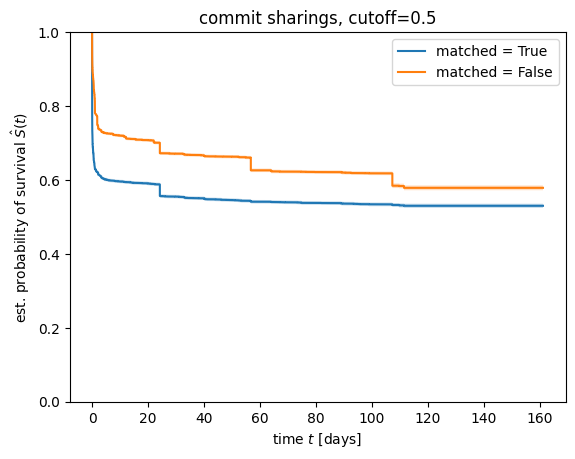

In [102]:
for matched_status in (True, False):
    mask_treat = df_commit_join["matches"] == matched_status
    time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
        df_commit_join["E"][mask_treat],
        df_commit_join["T"][mask_treat],
        conf_type="log-log",
    )

    plt.step(time_treatment, survival_prob_treatment, where="post", label=f"matched = {matched_status}")
    plt.fill_between(time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.title('commit sharings, cutoff=0.5')
plt.legend(loc="best")

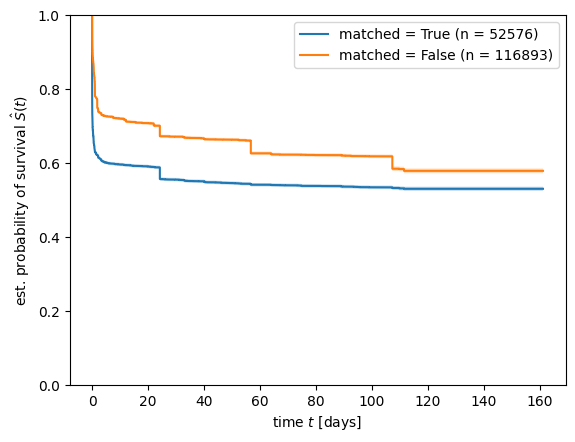

In [103]:
for value in df_commit_join["matches"].unique():
    mask = df_commit_join["matches"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df_commit_join["E"][mask],
        df_commit_join["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"matched = {value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.legend(loc="best")

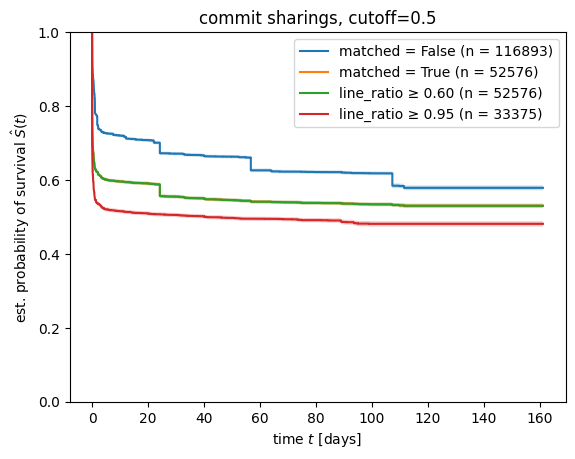

In [104]:
mask = ~df_commit_join["matches"]
time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
    df_commit_join["E"][mask],
    df_commit_join["T"][mask],
    conf_type="log-log"
)
plt.step(time_cell, survival_prob_cell, where="post", label=f"matched = False (n = {mask.sum()})")
plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

mask = df_commit_join["matches"]
time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
    df_commit_join["E"][mask],
    df_commit_join["T"][mask],
    conf_type="log-log"
)
plt.step(time_cell, survival_prob_cell, where="post", label=f"matched = True (n = {mask.sum()})")
plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

ratio_threshold = 0.60
mask = df_commit_join["postimage_max_line_ratio"] >= ratio_threshold
time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
    df_commit_join["E"][mask],
    df_commit_join["T"][mask],
    conf_type="log-log"
)
plt.step(time_cell, survival_prob_cell, where="post", label=f"line_ratio ≥ {ratio_threshold:.2f} (n = {mask.sum()})")
plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

ratio_threshold = 0.95
mask = df_commit_join["postimage_max_line_ratio"] >= ratio_threshold
time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
    df_commit_join["E"][mask],
    df_commit_join["T"][mask],
    conf_type="log-log"
)
plt.step(time_cell, survival_prob_cell, where="post", label=f"line_ratio ≥ {ratio_threshold:.2f} (n = {mask.sum()})")
plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")


# mask = (df_commit_join["postimage_max_line_ratio"] < ratio_threshold) & df_commit_join["matches"]
# time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
#     df_commit_join["E"][mask],
#     df_commit_join["T"][mask],
#     conf_type="log-log"
# )
# plt.step(time_cell, survival_prob_cell, where="post", label=f"0.5 ≤ line_ratio < {ratio_threshold} (n = {mask.sum()})")
# plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")


plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.title('commit sharings, cutoff=0.5')
plt.legend(loc="best")

In [105]:
def plot_lines_survival_matches(df, title="unknown sharings"):
    mask = ~df["matches"]
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df["E"][mask],
        df["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"matched = False (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
    
    mask = df["matches"]
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df["E"][mask],
        df["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"matched = True (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
    
    ratio_threshold = 0.60
    mask = df["postimage_max_line_ratio"] >= ratio_threshold
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df["E"][mask],
        df["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"line_ratio ≥ {ratio_threshold:.2f} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
    
    ratio_threshold = 0.95
    mask = df["postimage_max_line_ratio"] >= ratio_threshold
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df["E"][mask],
        df["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"line_ratio ≥ {ratio_threshold:.2f} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")
    
    plt.ylim(0, 1)
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$ [days]")
    plt.title(f'{title}, cutoff=0.5')
    plt.legend(loc="best")
    plt.show()

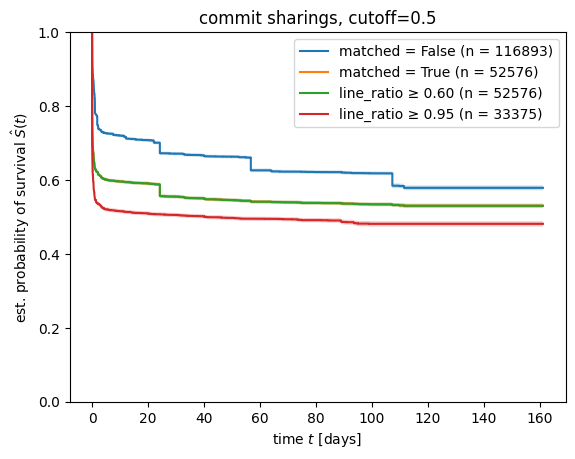

In [106]:
plot_lines_survival_matches(df_commit_join, title="commit sharings")

In [107]:
line_mask = df_commit_join['line'].str.len() > 1
line_mask.value_counts()

line
True     145315
False     24154
Name: count, dtype: int64

In [108]:
df_commit_join['line'].isna().sum()

22239

In [109]:
df_commit_join[line_mask]['line'].isna().sum()

0

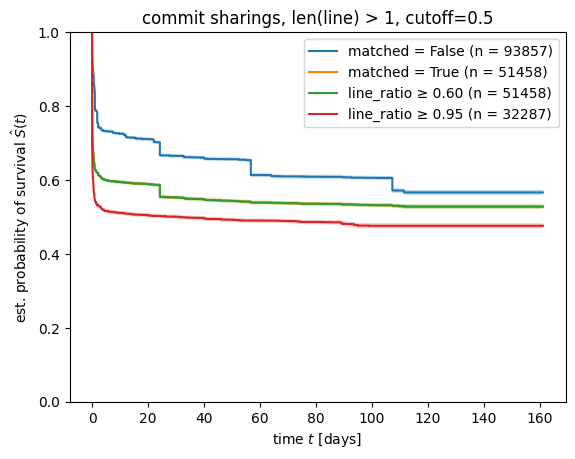

In [110]:
plot_lines_survival_matches(df_commit_join[line_mask], title="commit sharings, len(line) > 1")

## PR sharings

In [111]:
df_pr.columns

Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E', 'outlier'],
      dtype='object')

In [112]:
df_pr_sim = pd.read_csv('../data/interim/pr_mergesha_sharings_similarities_df.csv')
df_pr_sim.columns

Index(['URL', 'RepoName', 'Sha', 'Prev', 'NumberOfChatGptSharings',
       'postimage_all', 'postimage_coverage', 'preimage_all',
       'preimage_coverage', 'filename', 'path_a', 'path_b', 'hunk_idx',
       'n_matched_lines', 'preimage_Prompt_ratio', 'postimage_Answer_ratio',
       'postimage_ListOfCode_ratio', 'diff_line_no', 'matches',
       'postimage_Answer_line_ratio', 'postimage_ListOfCode_line_ratio'],
      dtype='object')

In [113]:
def df_join_sim(df, df_sim):
    df_sim.loc[:, 'postimage_max_line_ratio'] = df_sim[['postimage_Answer_line_ratio', 'postimage_ListOfCode_line_ratio']].max(axis=1)
    
    df_join = pd.merge(df, df_sim, how='left', on=['URL', 'RepoName', 'Sha', 'diff_line_no'])
    df_join['matches'].fillna(value=False, inplace=True)

    print(f"left merged {df.shape} and {df_sim.shape} into {df_join.shape}")
    
    return df_join

In [114]:
df_pr_join = df_join_sim(df_pr, df_pr_sim)
df_pr_join.columns

left merged (126967, 31) and (25353, 22) into (129938, 49)


Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E', 'outlier', 'Prev',
       'NumberOfChatGptSharings', 'postimage_all', 'postimage_coverage',
       'preimage_all', 'preimage_coverage', 'filename', 'path_a', 'path_b',
       'hunk_idx', 'n_matched_lines', 'preimage_Prompt_ratio',
       'postimage_Answer_ratio', 'postimage_ListOfCode_ratio', 'matches',
       'postimage_Answer_line_ratio', 'postimage_ListOfCode_line_ratio',
       'po

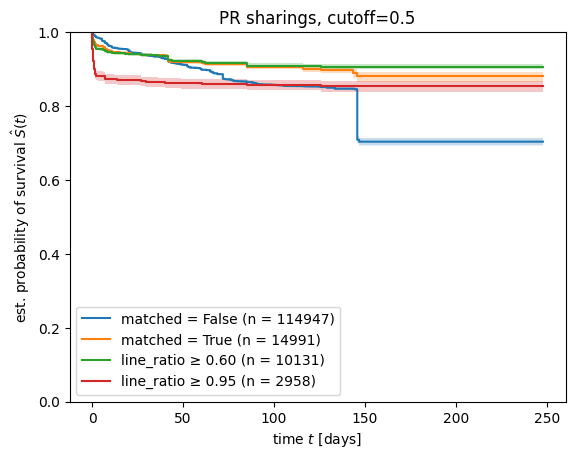

In [115]:
plot_lines_survival_matches(df_pr_join, title="PR sharings")

In [116]:
line_mask = df_pr_join['line'].str.len() > 1
line_mask.value_counts()

line
True     122522
False      7416
Name: count, dtype: int64

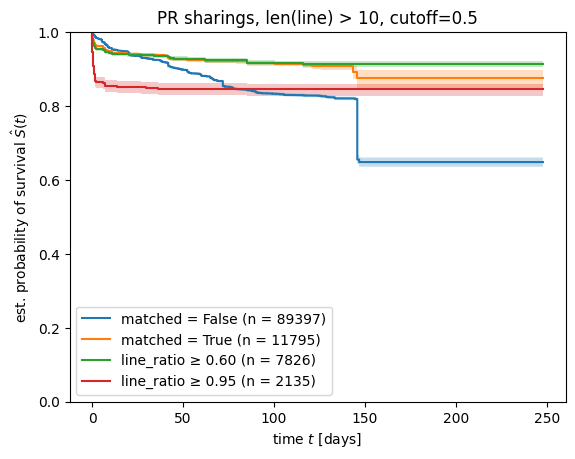

In [117]:
min_line_length = 10
plot_lines_survival_matches(df_pr_join[df_pr_join['line'].str.len() > min_line_length],
                            title=f"PR sharings, len(line) > {min_line_length}")

## Issue sharings

In [118]:
df_issue_sim = pd.read_csv('../data/interim/issue_sharings_similarities_df.csv')

In [119]:
df_issue_join = df_join_sim(df_issue, df_issue_sim)
df_issue_join.columns

left merged (71521, 30) and (3491, 22) into (71532, 48)


Index(['URL', 'RepoName', 'Sha', 'Sha_filename', 'Sha_lineno', 'last_commit',
       'last_filename', 'last_lineno', 'line', 'diff_line_no', 'next_commit',
       'next_filename', 'Sha_author_timestamp', 'Sha_committer_timestamp',
       'last_author_timestamp', 'last_committer_timestamp',
       'next_author_timestamp', 'next_committer_timestamp', 'has_next',
       'Sha_committer_time', 'last_committer_time', 'next_committer_time',
       'survival_duration', 'survival_duration_days', 'unchanged_duration',
       'unchanged_duration_days', 'observed_duration',
       'observed_duration_days', 'T', 'E', 'Prev', 'NumberOfChatGptSharings',
       'postimage_all', 'postimage_coverage', 'preimage_all',
       'preimage_coverage', 'filename', 'path_a', 'path_b', 'hunk_idx',
       'n_matched_lines', 'preimage_Prompt_ratio', 'postimage_Answer_ratio',
       'postimage_ListOfCode_ratio', 'matches', 'postimage_Answer_line_ratio',
       'postimage_ListOfCode_line_ratio', 'postimage_max_line_r

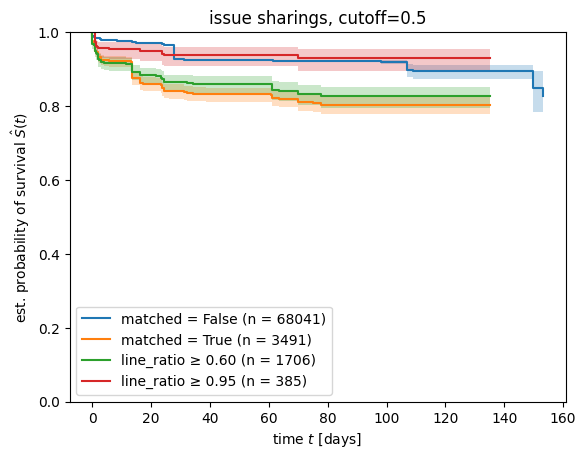

In [120]:
plot_lines_survival_matches(df_issue_join, title="issue sharings")

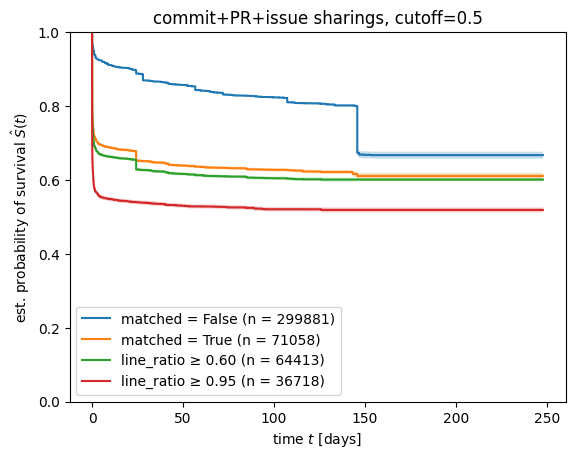

In [121]:
plot_lines_survival_matches(pd.concat([df_commit_join, df_pr_join, df_issue_join]), title="commit+PR+issue sharings")

## Compare different sharings

In [122]:
colors = sns.color_palette("Paired")
colors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [123]:
colors[0]

(0.6509803921568628, 0.807843137254902, 0.8901960784313725)

In [124]:
def print_stats(df):
    # include only actual events (i.e. lines for which survival time is known)
    print(f"total  = {df['T'].count()}")

    stats = df['T'].agg(['count', 'median'])
    
    print(f"count  = {int(stats['count'])} (including censored)")
    print(f"median = {stats['median']} days (including censored)")
    
    df = df[df['E']]
    
    stats = df['T'].agg(['count', 'median'])
    
    print(f"count  = {int(stats['count'])}")
    print(f"median = {stats['median']} days")

    s_mad = (df['T'] - stats['median']).abs()
    print(f"MAD    = {s_mad.median()} (median absolute deviation from median)")
    print(f"k*MAD  = {1.4826*s_mad.median()} rescaled (for normal distribution)")

    quartiles = df['T'].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    print(f"IQR    = {iqr} (interquartile range)")

    boot = bootstrap((df['T'],), np.median, confidence_level=0.95, method='percentile')
    print(f"CI     = [{boot.confidence_interval.low}, {boot.confidence_interval.high}] (bootstrap confidence interval for 95%)")
    print(f"CI     = {boot.confidence_interval}")
    print(f"CI_hl  = {boot.confidence_interval.high - boot.confidence_interval.low} (CI_high - CI_low)")
    print(f"std_b  = {boot.standard_error} (bootstrap standard error for 95%)")

    print("")
    
    # fig, ax = plt.subplots()
    # ax.hist(boot.bootstrap_distribution, bins=25)
    # ax.set_title('Bootstrap Distribution (confidence=95%)')
    # ax.set_xlabel('median lifetime $t$ [days]')
    # ax.set_ylabel('frequency')
    # plt.show()

In [125]:
df_commit_join['T'].median()

0.03082175925925926

In [126]:
df_commit_join[df_commit_join['E']]['T'].median()

0.0715625

In [127]:
df_commit_join['survival_duration_days'].median()

0.0715625

In [128]:
df_commit_join['T'].describe()

count    169469.000000
mean         20.223703
std          35.022138
min           0.000000
25%           0.030822
50%           0.030822
75%          36.031493
max         161.164861
Name: T, dtype: float64

In [129]:
df_commit_join[df_commit_join['E']]['T'].describe()

count    39171.000000
mean         5.725990
std         15.639174
min          0.000012
25%          0.014734
50%          0.071563
75%          1.001898
max        111.494988
Name: T, dtype: float64

In [130]:
%%time
print("commit sharings")
print_stats(df_commit_join)

commit sharings
total  = 169469
count  = 169469 (including censored)
median = 0.03082175925925926 days (including censored)
count  = 39171
median = 0.0715625 days
MAD    = 0.06854166666666667 (median absolute deviation from median)
k*MAD  = 0.101619875 rescaled (for normal distribution)
IQR    = 0.9871643518518518 (interquartile range)
CI     = [0.06734953703703704, 0.0764699074074074] (bootstrap confidence interval for 95%)
CI     = ConfidenceInterval(low=0.06734953703703704, high=0.0764699074074074)
CI_hl  = 0.009120370370370362 (CI_high - CI_low)
std_b  = 0.0024655064094730767 (bootstrap standard error for 95%)

CPU times: user 9.2 s, sys: 5.29 s, total: 14.5 s
Wall time: 14.5 s


In [131]:
def plot_lines_survival_pair(df, ratio_threshold=0.6, title="unknown sharing",
                             color_pair_idx=0, color_palette=sns.color_palette("Paired"),
                             show_stats=False):
    if show_stats:
        print(f"{title}")
        print_stats(df)
    
    mask = ~df["matches"]
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df["E"][mask],
        df["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell,
             where="post", color=color_palette[2*color_pair_idx],
             label=f"{title} matched = False (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1],
                     color=color_palette[2*color_pair_idx],
                     alpha=0.25, step="post")

    if show_stats:
        print(f"{title} matched = False (n = {mask.sum()})")
        print_stats(df[mask])
    
    mask = df["postimage_max_line_ratio"] >= ratio_threshold
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        df["E"][mask],
        df["T"][mask],
        conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell,
             where="post", color=color_palette[2*color_pair_idx+1],
             label=f"{title} line_ratio ≥ {ratio_threshold:.2f} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1],
                     color=color_palette[2*color_pair_idx+1],
                     alpha=0.25, step="post")

    mask_both = ~df["matches"] | (df["postimage_max_line_ratio"] >= ratio_threshold)
    print(f"{mask_both.sum()=}")

    if show_stats:
        print(f"{title} line_ratio ≥ {ratio_threshold:.2f} (n = {mask.sum()})")
        print_stats(df[mask])

commit sharing
total  = 169469
count  = 169469 (including censored)
median = 0.03082175925925926 days (including censored)
count  = 39171
median = 0.0715625 days
MAD    = 0.06854166666666667 (median absolute deviation from median)
k*MAD  = 0.101619875 rescaled (for normal distribution)
IQR    = 0.9871643518518518 (interquartile range)
CI     = [0.06734953703703704, 0.0764699074074074] (bootstrap confidence interval for 95%)
CI     = ConfidenceInterval(low=0.06734953703703704, high=0.0764699074074074)
CI_hl  = 0.009120370370370362 (CI_high - CI_low)
std_b  = 0.00245902648488636 (bootstrap standard error for 95%)

commit sharing matched = False (n = 116893)
total  = 116893
count  = 116893 (including censored)
median = 0.03082175925925926 days (including censored)
count  = 18508
median = 0.5793402777777777 days
MAD    = 0.5619097222222222 (median absolute deviation from median)
k*MAD  = 0.8330873541666667 rescaled (for normal distribution)
IQR    = 2.034537037037037 (interquartile range)


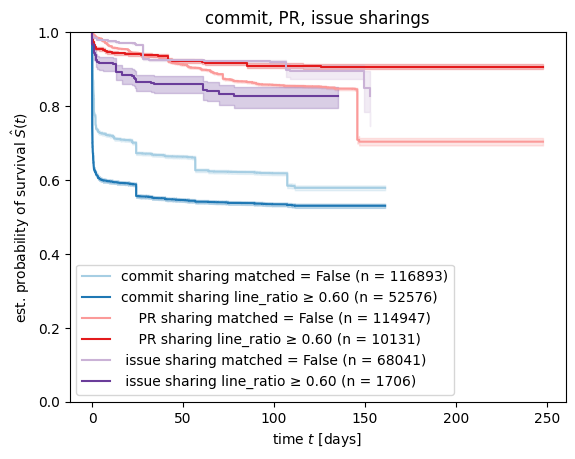

In [132]:
show_stats=True
plot_lines_survival_pair(df_commit_join, title="commit sharing", color_pair_idx=0, show_stats=show_stats)
plot_lines_survival_pair(df_pr_join,     title="    PR sharing", color_pair_idx=2, show_stats=show_stats)
plot_lines_survival_pair(df_issue_join,  title=" issue sharing", color_pair_idx=4, show_stats=show_stats)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.title(f"commit, PR, issue sharings")
plt.legend(loc="best")
plt.show()

commit sharing
total  = 169469
count  = 169469 (including censored)
median = 0.03082175925925926 days (including censored)
count  = 39171
median = 0.0715625 days
MAD    = 0.06854166666666667 (median absolute deviation from median)
k*MAD  = 0.101619875 rescaled (for normal distribution)
IQR    = 0.9871643518518518 (interquartile range)
CI     = [0.06734953703703704, 0.0764699074074074] (bootstrap confidence interval for 95%)
CI     = ConfidenceInterval(low=0.06734953703703704, high=0.0764699074074074)
CI_hl  = 0.009120370370370362 (CI_high - CI_low)
std_b  = 0.0024982220030128274 (bootstrap standard error for 95%)

commit sharing matched = False (n = 116893)
total  = 116893
count  = 116893 (including censored)
median = 0.03082175925925926 days (including censored)
count  = 18508
median = 0.5793402777777777 days
MAD    = 0.5619097222222222 (median absolute deviation from median)
k*MAD  = 0.8330873541666667 rescaled (for normal distribution)
IQR    = 2.034537037037037 (interquartile range

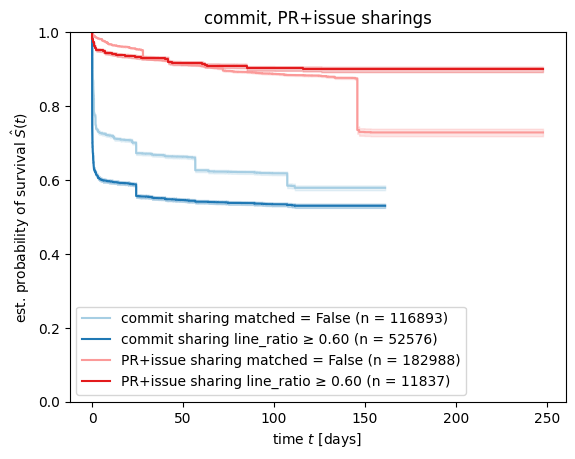

CPU times: user 23.7 s, sys: 5.95 s, total: 29.6 s
Wall time: 29.4 s


In [133]:
%%time

show_stats=True
plot_lines_survival_pair(df_commit_join,
                         title="commit sharing", color_pair_idx=0, show_stats=show_stats)
plot_lines_survival_pair(pd.concat([df_pr_join, df_issue_join]),
                         title="PR+issue sharing", color_pair_idx=2, show_stats=show_stats)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.title(f"commit, PR+issue sharings")
plt.legend(loc="best")
plt.show()

## Joint commit+PR+issue sharings

sharing
total  = 370939
count  = 370939 (including censored)
median = 18.99644675925926 days (including censored)
count  = 53711
median = 0.5716782407407407 days
MAD    = 0.5653703703703703 (median absolute deviation from median)
k*MAD  = 0.838218111111111 rescaled (for normal distribution)
IQR    = 11.135127314814815 (interquartile range)
CI     = [0.5430902777777777, 0.5820138888888889] (bootstrap confidence interval for 95%)
CI     = ConfidenceInterval(low=0.5430902777777777, high=0.5820138888888889)
CI_hl  = 0.0389236111111112 (CI_high - CI_low)
std_b  = 0.012374810962194418 (bootstrap standard error for 95%)

sharing matched = False (n = 299881)
total  = 299881
count  = 299881 (including censored)
median = 18.99644675925926 days (including censored)
count  = 31736
median = 1.8533564814814816 days
MAD    = 1.8473148148148149 (median absolute deviation from median)
k*MAD  = 2.7388289444444442 rescaled (for normal distribution)
IQR    = 24.13767361111111 (interquartile range)
CI     

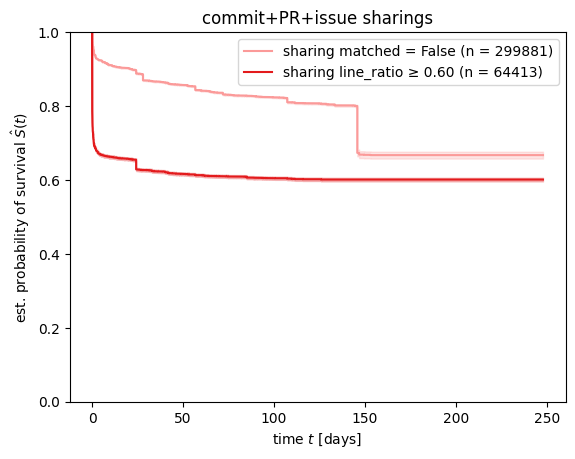

CPU times: user 19.2 s, sys: 6.28 s, total: 25.5 s
Wall time: 25.1 s


In [135]:
%%time

show_stats=True
plot_lines_survival_pair(pd.concat([df_commit_join, df_pr_join, df_issue_join]),
                         title="sharing", color_pair_idx=2, show_stats=show_stats)

plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.title(f"commit+PR+issue sharings")
plt.legend(loc="best")

plt.savefig('lines_survival_pair-concat_commit+pr+issue.pdf')
plt.show()

mask_both.sum()=351316


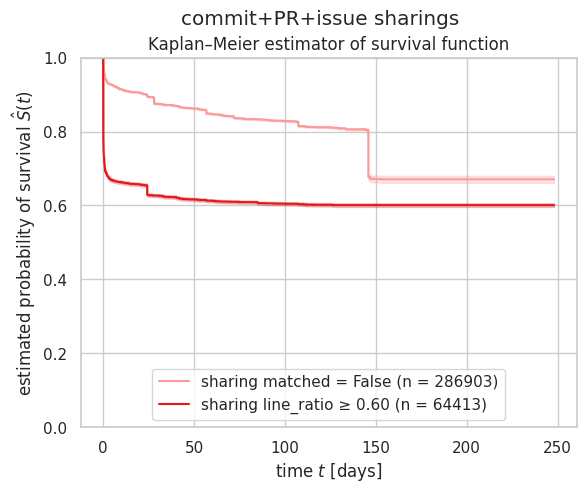

In [294]:
show_stats=False

sns.set_theme()
sns.set_style('whitegrid')

plot_lines_survival_pair(pd.concat([df_commit_join, df_pr_join, df_issue_join]),
                         title="sharing", color_pair_idx=2, show_stats=show_stats)

plt.ylim(0, 1)
plt.ylabel("estimated probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.suptitle("commit+PR+issue sharings")
plt.title("Kaplan–Meier estimator of survival function")

plt.legend(loc="lower center")
plt.show()

In [259]:
df_all_join = pd.concat([df_commit_join, df_pr_join, df_issue_join])

In [260]:
df_all_join['T'].describe()

count    370939.000000
mean         35.250172
std          41.489592
min           0.000000
25%           0.030822
50%          18.996447
75%          65.778738
max         247.988044
Name: T, dtype: float64

In [261]:
df_all_join['T'][df_all_join['E']].describe()

count    53711.000000
mean        12.054370
std         25.296324
min          0.000012
25%          0.022986
50%          0.571678
75%         11.158113
max        153.127095
Name: T, dtype: float64

mask_both.sum()=351316
mask_both.sum()=51327


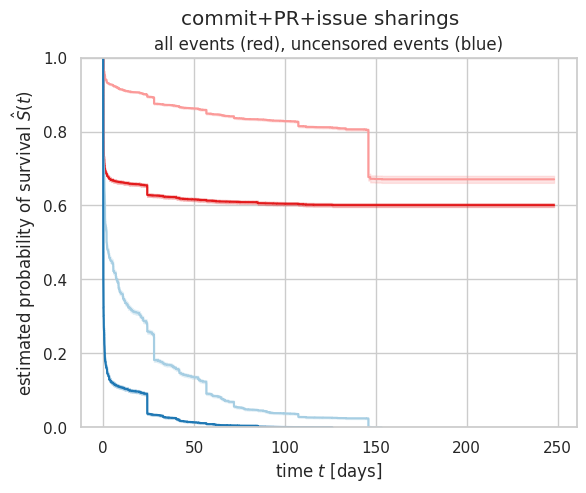

In [301]:
show_stats=False

sns.set_theme()
sns.set_style('whitegrid')

plot_lines_survival_pair(df_all_join,
                         title="sharing all", color_pair_idx=2, show_stats=show_stats)
plot_lines_survival_pair(df_all_join[df_all_join['E']],
                         title="sharing event", color_pair_idx=0, show_stats=show_stats)

plt.ylim(0, 1)
plt.ylabel("estimated probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ [days]")
plt.suptitle("commit+PR+issue sharings")
plt.title("all events (red), uncensored events (blue)")

plt.show()

### Compare survival, concordance index / Dxy

In [263]:
ratio_threshold= 0.6

mask_1 = ~df_all_join["matches"]
mask_2 = df_all_join["postimage_max_line_ratio"] >= ratio_threshold

print(f"{mask_1.sum()=}")
print(f"{mask_2.sum()=}")

mask_1.sum()=286903
mask_2.sum()=64413


In [264]:
mask_12 = mask_1 | mask_2

print(f"{mask_12.sum()=}")

mask_12.sum()=351316


In [266]:
df_all_join.loc[mask_1, 'group'] = "matched = False"
df_all_join.loc[mask_2, 'group'] = "line_ratio ≥ 0.60"

df_all_join['group'].value_counts()

group
matched = False      286903
line_ratio ≥ 0.60     64413
nan                   19623
Name: count, dtype: int64

In [283]:
# https://stackoverflow.com/questions/46837472/converting-pandas-dataframe-to-structured-arrays
df_all_join[['E', 'T']].set_index('E').to_records()

rec.array([( True, 44.7272338 ), ( True, 44.7272338 ),
           ( True, 44.7272338 ), ..., ( True, 41.6581713 ),
           ( True, 41.6581713 ), ( True, 60.45342593)],
          dtype=[('E', '?'), ('T', '<f8')])

In [274]:
df_all_join['group'].to_numpy()

array(['line_ratio ≥ 0.60', 'line_ratio ≥ 0.60', 'matched = False', ...,
       'matched = False', 'matched = False', 'matched = False'],
      dtype=object)

In [275]:
compare_survival(y=df_all_join[['E', 'T']].set_index('E').to_records(),
                 group_indicator=df_all_join['group'].to_numpy(),
                 return_stats=True)

(23341.072657975445,
 0.0,
                    counts  observed      expected     statistic
 group                                                          
 line_ratio ≥ 0.60   64413     21572   8664.124393  12907.875607
 matched = False    286903     29755  42755.172310 -13000.172310
 nan                 19623      2384   2291.703297     92.296703,
 array([[ 7219.34533914, -6849.62659472,  -369.71874442],
        [-6849.62659472,  8662.03203464, -1812.40543992],
        [ -369.71874442, -1812.40543992,  2182.12418433]]))

In [276]:
compare_survival(y=df_all_join[mask_12][['E', 'T']].set_index('E').to_records(),
                 group_indicator=df_all_join[mask_12]['group'].to_numpy(),
                 return_stats=True)

(23450.001894371453,
 0.0,
                    counts  observed      expected     statistic
 group                                                          
 line_ratio ≥ 0.60   64413     21572   8636.363651  12935.636349
 matched = False    286903     29755  42690.636349 -12935.636349,
 array([[ 7135.63642816, -7135.63642816],
        [-7135.63642816,  7135.63642816]]))

In [277]:
df_all_join.loc[mask_1, 'risk'] = 1
df_all_join.loc[mask_2, 'risk'] = 2

df_all_join['risk'].value_counts()

risk
1.0    286903
2.0     64413
Name: count, dtype: int64

In [287]:
# from scikit-survival
c = concordance_index_censored(event_indicator=df_all_join[mask_12]['E'],
                               event_time=df_all_join[mask_12]['T'],
                               estimate=df_all_join[mask_12]['risk'],
                               tied_tol=1e-08)
print(f"concordanced index {c[0]} (concordance index for right-censored data, Harrell et al.)")
print(f"Dxy = {2*c[0] - 1}")
c

concordanced index 0.6596347696348753 (concordance index for right-censored data, Harrell et al.)
Dxy = 0.31926953926975066


(0.6596347696348753, 4901773009, 1035722940, 6171551716, 57435)

In [284]:
# c_alt = concordance_index_ipcw(event_indicator=df_all_join[mask_12]['E'],
#                                event_time=df_all_join[mask_12]['T'],
#                                estimate=df_all_join[mask_12]['risk'],
#                                tied_tol=1e-08)
# print(f"concordanced index {c_alt[0]} (inverse probability of censoring weights, Uno et al.)")
# print(f"Dxy = {2*c_alt[0] - 1}")
# c_alt

In [289]:
# from lifelines
cc = concordance_index(event_observed=df_all_join[mask_12]['E'],
                       event_times=df_all_join[mask_12]['T'],
                       predicted_scores=df_all_join[mask_12]['risk'])
print(f"concordanced index {cc} (concordance index for right-censored data, Harrell et al.)")
print(f"Dxy = {2*cc - 1}")
cc

concordanced index 0.34036523036512467 (concordance index for right-censored data, Harrell et al.)
Dxy = -0.31926953926975066


0.34036523036512467